In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import matplotlib.image as mpimg 

In [18]:
def Gradient_Magnitude(img): 
    kernelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #we use sobel filters in each direction 
    kernely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    imgx = cv2.filter2D(img,-1,kernelx) #we convolve the filters
    imgy = cv2.filter2D(img,-1,kernely)
    imgmag = img.copy()
    if isinstance(img[0][0],np.uint8): #grayscale image support
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                imgmag[i][j] = math.sqrt(imgx[i][j]**2 + imgy[i][j]**2)
    else:
        for i in range(img.shape[0]): #colorimage
            for j in range(img.shape[1]):
                imgmag[i][j][0] = math.sqrt(imgx[i][j][0]**2 + imgy[i][j][0]**2)
                imgmag[i][j][1] = math.sqrt(imgx[i][j][1]**2 + imgy[i][j][1]**2)
                imgmag[i][j][2] = math.sqrt(imgx[i][j][2]**2 + imgy[i][j][2]**2)
    return imgmag

def Laplacian_(img): 
    kernell = np.array([[0,1,0],[1,-4,1],[0,1,0]]) #this is the laplacian filter
    imgl = cv2.filter2D(img,ddepth=cv2.CV_32F, kernel = kernell) #we convolve in float mode to have negative values and account for change
    return imgl

def zerocrossings(imgl):
    signimg = np.sign(imgl) #we get sign of laplacian
    xtruthval = signimg[:-1, :-1] - signimg[:-1, 1:] < 0 #we substract horizontally and set truth value accordingly
    ytruthval = signimg[:-1, :-1] - signimg[1:, :-1] < 0 #we substract vertically 
    crossings =  np.logical_or(xtruthval, ytruthval).astype(float) #if there is a True change in value we set 1
    return crossings

def Laplacian_Edge_Detection(img,threshold): #we input image and threshold value from 0 to 255
    imgm = Gradient_Magnitude(img) #we evaluate gradient magnitude
    imgt = img.copy()
    if isinstance(img[0][0],np.uint8):
        for i in range(imgm.shape[0]):
            for j in range(imgm.shape[1]):
                if imgm[i][j] > threshold: #we set white if above threshold and black if below
                    imgt[i][j] = 255
                else:
                    imgt[i][j] = 0
    else:
        for i in range(imgm.shape[0]):
            for j in range(imgm.shape[1]):
                if (imgm[i][j][0] > threshold) or (imgm[i][j][1] > threshold) or (imgm[i][j][2] > threshold):
                    imgt[i][j][0] = 255
                    imgt[i][j][1] = 255
                    imgt[i][j][2] = 255
                else:
                    imgt[i][j][0] = 0
                    imgt[i][j][1] = 0
                    imgt[i][j][2] = 0
    kernelG = np.array([[0,0,-1,0,0],[0,-1,-2,-1,0],[-1,-2,16,-2,-1],[0,-1,-2,-1,0],[0,0,-1,0,0]])
    imgG = cv2.filter2D(imgt,-1,kernelG) #we convolve with Gaussian smoothing filter
    imgl = Laplacian_(imgG) #we apply laplacian filter
    zc = zerocrossings(imgl) #we get contours image
    return zc

def propercolor(img1):
    b,g,r = cv2.split(img1) #this converts image properly when read through cv2
    rgb_img1 = cv2.merge([r,g,b]) 
    return rgb_img1

In [16]:
pic = cv2.imread('rose.jpeg')
ed = Laplacian_Edge_Detection(pic,20)

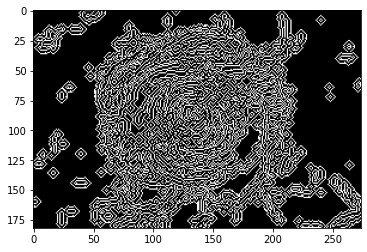

In [31]:
plt.imshow(ed)

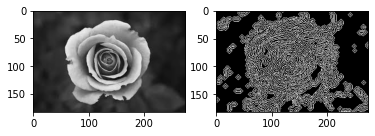

In [29]:
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(ed)

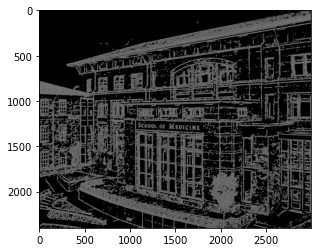

In [19]:
openc = cv2.imread('emory.jpg')
pic1 = propercolor(openc)
ed1 = Laplacian_Edge_Detection(pic1,100)
plt.imshow(ed1)

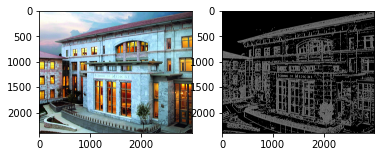

In [22]:
plt.subplot(1,2,1)
plt.imshow(pic1)
plt.subplot(1,2,2)
plt.imshow(ed1)

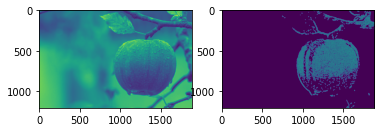

In [27]:
f = plt.figure(figsize=(10,3))
pic3 = mpimg.imread('gray.jpeg')
ed3 = Laplacian_Edge_Detection(pic3,100)
plt.subplot(1,2,1)
plt.imshow(pic3)
plt.subplot(1,2,2)
plt.imshow(ed3)

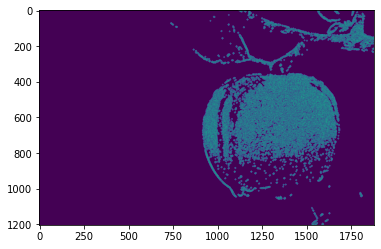

In [32]:
plt.imshow(ed3)